GT4Py - GridTools4Py - GridTools for Python

Copyright (c) 2014-2019, ETH Zurich
All rights reserved.

This file is part the GT4Py project and the GridTools framework.
GT4Py is free software: you can redistribute it and/or modify it under
the terms of the GNU General Public License as published by the
Free Software Foundation, either version 3 of the License, or any later
version. See the LICENSE.txt file at the top-level directory of this
distribution for a copy of the license or check <https://www.gnu.org/licenses/>.

SPDX-License-Identifier: GPL-3.0-or-later


## Horizontal Diffusion Example

### Imports and utilities

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import gt4py
import gt4py.gtscript as gtscript
import gt4py.storage as gt_storage

### Global definitions

In [10]:
backend="gt:gpu" # "numpy", "gt:cpu_ifirst", "gt:gpu"
dtype = np.float64

### Define GTScript stencil

In [11]:

@gtscript.stencil(backend=backend) # this decorator triggers compilation of the stencil
def horizontal_diffusion(
    in_field: gtscript.Field[dtype],
    out_field: gtscript.Field[dtype],
    coeff: gtscript.Field[dtype],
):
    with computation(PARALLEL), interval(...):
        lap_field = 4.0 * in_field[0, 0, 0] - (
            in_field[1, 0, 0] + in_field[-1, 0, 0] + in_field[0, 1, 0] + in_field[0, -1, 0]
        )
        res = lap_field[1, 0, 0] - lap_field[0, 0, 0]
        flx_field = 0 if (res * (in_field[1, 0, 0] - in_field[0, 0, 0])) > 0 else res
        res = lap_field[0, 1, 0] - lap_field[0, 0, 0]
        fly_field = 0 if (res * (in_field[0, 1, 0] - in_field[0, 0, 0])) > 0 else res
        out_field = in_field[0, 0, 0] - coeff[0, 0, 0] * (
            flx_field[0, 0, 0] - flx_field[-1, 0, 0] + fly_field[0, 0, 0] - fly_field[0, -1, 0]
        )


Traceback (most recent call last):
  File "/home/Niki.Zadeh/opt/miniconda/envs/om4labs/lib/python3.8/site-packages/setuptools/_distutils/unixccompiler.py", line 186, in _compile
    self.spawn(compiler_so + cc_args + [src, '-o', obj] + extra_postargs)
  File "/home/Niki.Zadeh/opt/miniconda/envs/om4labs/lib/python3.8/site-packages/setuptools/_distutils/ccompiler.py", line 987, in spawn
    spawn(cmd, dry_run=self.dry_run, **kwargs)
  File "/home/Niki.Zadeh/opt/miniconda/envs/om4labs/lib/python3.8/site-packages/setuptools/_distutils/spawn.py", line 70, in spawn
    raise DistutilsExecError(
distutils.errors.DistutilsExecError: command '/usr/local/cuda/bin/nvcc' failed with exit code 1

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/Niki.Zadeh/opt/miniconda/envs/om4labs/lib/python3.8/site-packages/setuptools/_distutils/core.py", line 201, in run_commands
    dist.run_commands()
  File "/home/Niki.Zadeh/opt/miniconda/en

TypeError: object of type 'NoneType' has no len()

### Initialize Fields

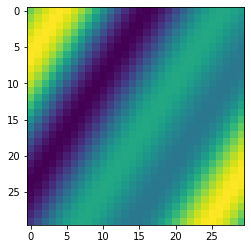

In [4]:
# Initialize example data
N = 30
shape = [N] * 3
origin = (2, 2, 0)

indices = np.arange(N)
ii = np.zeros((N, N, N)) + np.reshape(indices, (N, 1, 1))
jj = np.zeros((N, N, N)) + np.reshape(indices, (1, N, 1))
kk = np.zeros((N, N, N)) + np.reshape(indices, (1, 1, N))

xx = ii / N
yy = jj / N
zz = kk / N

in_data = 5. + 8. * (2. + np.cos(np.pi * (xx + 1.5 * yy)) + np.sin(2 * np.pi * (xx + 1.5 * yy))) / 4.
out_data = np.zeros(shape)
coeff_data = 0.025 * np.ones(shape)

# Plot initialization
projection = np.array(np.sum(in_data, axis=2))
plt.imshow(projection)


### Copy input data from numpy arrays to gt4py storages


In [5]:
in_storage = gt_storage.from_array(
    in_data, backend, default_origin=origin, dtype=dtype 
)
out_storage = gt_storage.from_array(
    out_data, backend, default_origin=origin, dtype=dtype, 
)
coeff_storage = gt_storage.from_array(
    coeff_data, backend, default_origin=origin, dtype=dtype, 
)

### Run computation

In [6]:
horizontal_diffusion(in_storage, out_storage, coeff_storage)

### Plot results

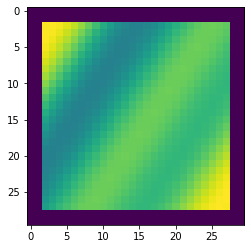

In [7]:
if backend=="gtcuda":
    out_storage.synchronize() # does a copy if the cpu or gpu buffer is modified.
    
projection = np.asarray(np.sum(out_storage, axis=2))
plt.imshow(projection)